# Importing Libraries and Data

In [1]:
# Manage Data
import numpy as np
import pandas as pd

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from functools import partial

# Processing data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import glob
import os

# Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# dataset available on https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
def get_df(dataset):
    image_dir = Path(dataset)
    
    filepaths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

train_df = get_df("/kaggle/input/intel-image-classification/seg_train")
test_df = get_df("/kaggle/input/intel-image-classification/seg_test")
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df.index = range(len(train_df))
valid_df.index = range(len(valid_df))

train_df

,Filepath,Label
0,/kaggle/input/intel-image-classification/seg_t...,sea
1,/kaggle/input/intel-image-classification/seg_t...,forest
2,/kaggle/input/intel-image-classification/seg_t...,buildings
3,/kaggle/input/intel-image-classification/seg_t...,forest
4,/kaggle/input/intel-image-classification/seg_t...,sea
...,...,...
11222,/kaggle/input/intel-image-classification/seg_t...,buildings
11223,/kaggle/input/intel-image-classification/seg_t...,glacier
11224,/kaggle/input/intel-image-classification/seg_t...,buildings
11225,/kaggle/input/intel-image-classification/seg_t...,mountain


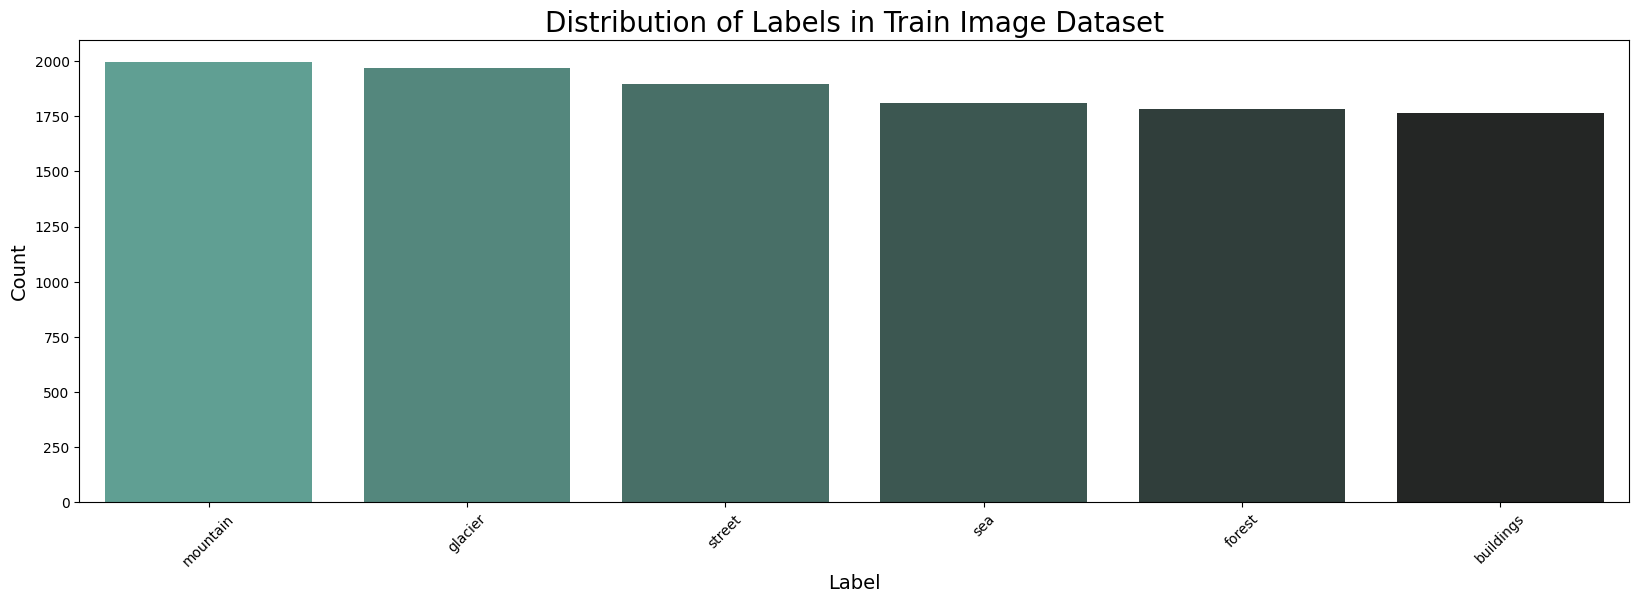

In [3]:
label_counts = train_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="dark:#5A9_r")
plt.title('Distribution of Labels in Train Image Dataset', fontsize=20)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

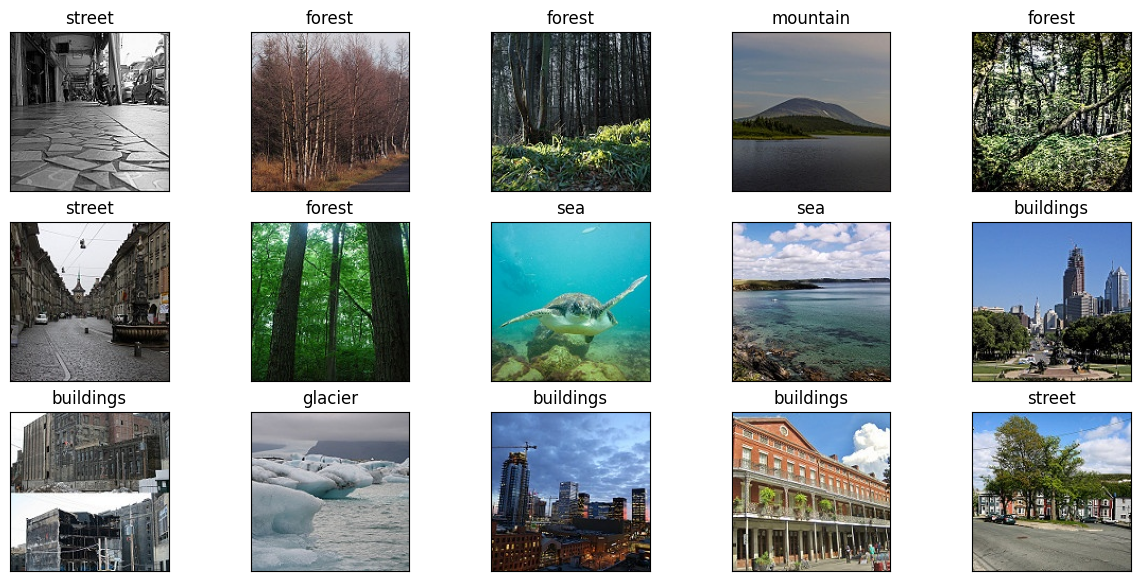

In [18]:
random_index = np.random.randint(0, len(train_df), 15)

w = 5; h = 3;
fig, axes = plt.subplots(h, w, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[random_index[i]]))
    ax.set_title(train_df.Label[random_index[i]])
plt.show()

In [3]:
Datagen = ImageDataGenerator(rescale=1./255)

X_train = Datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
X_valid = Datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)
X_test = Datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 11227 validated image filenames belonging to 6 classes.
Found 2807 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


# Training Models

## Some topics to improve the model

**1. Regularization:**
- *Batch Normalization*
- *Dropout*
- L1, *L2*, L1L2
- *Data Augmentation*

**2. Weight Initialization:**
- *HeNormal*

**3. Activation Functions:**
- ReLU
- *LeakyReLU*
- ELU

**4. Optimization:**
- SGD
- SGD+momentum
- Nesterov momentum
- AdaGrad
- RMSProp
- *Adam*

In [4]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### 1 - val_acc = 33.42%
BachNorm after each Conv layer + Dropout(0.5)

In [19]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same')

model1 = Sequential([
    DefaultConv2D(filters=32, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=32),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=64),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=6, activation='softmax')
])
model1.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history1 = model1.fit(X_train, verbose=1, epochs=5, validation_data=X_valid, validation_steps=None)

Epoch 1/5
351/351 [==============================] - 41s 96ms/step - loss: 2.2729 - accuracy: 0.2726 - val_loss: 1.8302 - val_accuracy: 0.1600
Epoch 2/5
351/351 [==============================] - 21s 60ms/step - loss: 1.6555 - accuracy: 0.2775 - val_loss: 1.5062 - val_accuracy: 0.3342
Epoch 3/5
351/351 [==============================] - 21s 59ms/step - loss: 1.6188 - accuracy: 0.2858 - val_loss: 8.0855 - val_accuracy: 0.1468
Epoch 4/5
351/351 [==============================] - 21s 59ms/step - loss: 1.6158 - accuracy: 0.2866 - val_loss: 1.5071 - val_accuracy: 0.3210
Epoch 5/5
351/351 [==============================] - 20s 58ms/step - loss: 1.5373 - accuracy: 0.3060 - val_loss: 1.4549 - val_accuracy: 0.3249


### 2 - val_acc = 62.34%
No BatchNorm and no Droupout

In [20]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same')

model2 = Sequential([
    Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same', input_shape=(150,150,3)),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation='relu'),
    #Dropout(0.5),
    Dense(units=64, activation='relu'),
    #Dropout(0.5),
    Dense(units=6, activation='softmax')
])
model2.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history2 = model2.fit(X_train, verbose=1, epochs=5, validation_data=X_valid, validation_steps=None)

Epoch 1/5
351/351 [==============================] - 26s 65ms/step - loss: 1.2815 - accuracy: 0.5143 - val_loss: 3.0764 - val_accuracy: 0.6234
Epoch 2/5
351/351 [==============================] - 23s 65ms/step - loss: 2.6771 - accuracy: 0.6257 - val_loss: 90.5054 - val_accuracy: 0.5030
Epoch 3/5
351/351 [==============================] - 22s 63ms/step - loss: 3.5916 - accuracy: 0.1889 - val_loss: 210.8262 - val_accuracy: 0.1820
Epoch 4/5
351/351 [==============================] - 22s 62ms/step - loss: 1.7910 - accuracy: 0.1779 - val_loss: 153.3515 - val_accuracy: 0.1842
Epoch 5/5
351/351 [==============================] - 22s 62ms/step - loss: 1.7909 - accuracy: 0.1746 - val_loss: 182.7933 - val_accuracy: 0.1842


### 3 - val_acc = 18.42
No BachNorm + Dropout(0.5)

In [21]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same')

model3 = Sequential([
    Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same', input_shape=(150,150,3)),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=6, activation='softmax')
])
model3.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history3 = model3.fit(X_train, verbose=1, epochs=5, validation_data=X_valid, validation_steps=None)

Epoch 1/5
351/351 [==============================] - 24s 62ms/step - loss: 1.9110 - accuracy: 0.1748 - val_loss: 16.4101 - val_accuracy: 0.1828
Epoch 2/5
351/351 [==============================] - 22s 63ms/step - loss: 2.5624 - accuracy: 0.1781 - val_loss: 127.1988 - val_accuracy: 0.1835
Epoch 3/5
351/351 [==============================] - 21s 60ms/step - loss: 1.7912 - accuracy: 0.1727 - val_loss: 89.7388 - val_accuracy: 0.1842
Epoch 4/5
351/351 [==============================] - 21s 61ms/step - loss: 1.7908 - accuracy: 0.1724 - val_loss: 109.4556 - val_accuracy: 0.1831
Epoch 5/5
351/351 [==============================] - 21s 61ms/step - loss: 1.7908 - accuracy: 0.1790 - val_loss: 103.0139 - val_accuracy: 0.1831


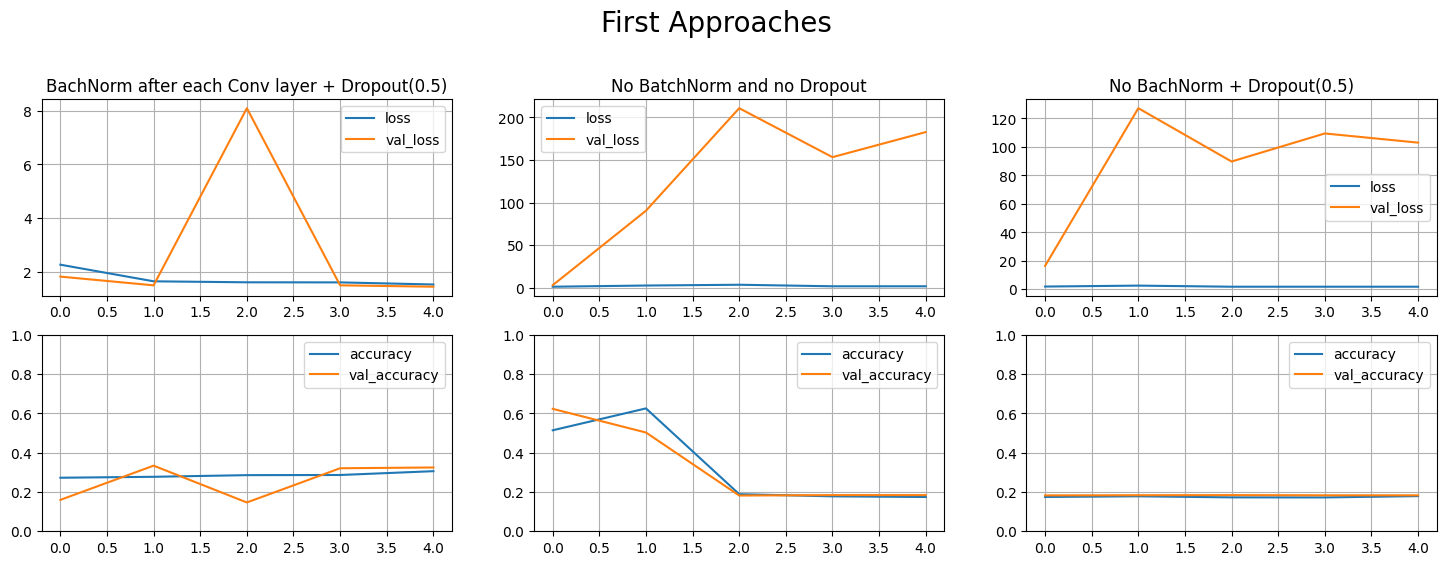

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
plt.suptitle("First Approaches", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(pd.DataFrame({'loss': history1.history['loss'], 'val_loss': history1.history['val_loss']})).plot(ax=axes[0][0])
axes[0][0].set_title("BachNorm after each Conv layer + Dropout(0.5)")
axes[0][0].grid(True)
pd.DataFrame(pd.DataFrame({'loss': history2.history['loss'], 'val_loss': history2.history['val_loss']})).plot(ax=axes[0][1])
axes[0][1].set_title("No BatchNorm and no Dropout")
axes[0][1].grid(True)
pd.DataFrame(pd.DataFrame({'loss': history3.history['loss'], 'val_loss': history3.history['val_loss']})).plot(ax=axes[0][2])
axes[0][2].set_title("No BachNorm + Dropout(0.5)")
axes[0][2].grid(True)

pd.DataFrame(pd.DataFrame({'accuracy': history1.history['accuracy'], 'val_accuracy': history1.history['val_accuracy']})).plot(ax=axes[1][0])
axes[1][0].grid(True)
axes[1][0].set_ylim(0,1)
pd.DataFrame(pd.DataFrame({'accuracy': history2.history['accuracy'], 'val_accuracy': history2.history['val_accuracy']})).plot(ax=axes[1][1])
axes[1][1].grid(True)
axes[1][1].set_ylim(0,1)
pd.DataFrame(pd.DataFrame({'accuracy': history3.history['accuracy'], 'val_accuracy': history3.history['val_accuracy']})).plot(ax=axes[1][2])
axes[1][2].grid(True)
axes[1][2].set_ylim(0,1)

plt.show()

### 4 - val_acc = 80.33%
BachNorm after each 2 Conv layer + Dropout(0.1) + 50 epochs

In [49]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same')

model4 = Sequential([
    Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.1),
    Dense(units=64, activation='relu'),
    Dropout(0.1),
    Dense(units=6, activation='softmax')
])

model4.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history4 = model4.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 36s 92ms/step - loss: 2.5141 - accuracy: 0.4335 - val_loss: 2.8552 - val_accuracy: 0.3502
Epoch 2/50
351/351 [==============================] - 24s 69ms/step - loss: 1.2255 - accuracy: 0.5424 - val_loss: 3.5177 - val_accuracy: 0.5786
Epoch 3/50
351/351 [==============================] - 24s 68ms/step - loss: 1.0200 - accuracy: 0.6027 - val_loss: 8.2690 - val_accuracy: 0.5490
Epoch 4/50
351/351 [==============================] - 24s 68ms/step - loss: 0.8725 - accuracy: 0.6690 - val_loss: 3.7972 - val_accuracy: 0.5949
Epoch 5/50
351/351 [==============================] - 24s 68ms/step - loss: 0.7598 - accuracy: 0.7136 - val_loss: 6.5630 - val_accuracy: 0.6505
Epoch 6/50
351/351 [==============================] - 24s 67ms/step - loss: 0.6688 - accuracy: 0.7527 - val_loss: 12.1957 - val_accuracy: 0.3691
Epoch 7/50
351/351 [==============================] - 24s 68ms/step - loss: 0.6053 - accuracy: 0.7759 - val_loss: 8.0765 - val_accuracy

### 5 - val_acc = 82.97%
BachNorm after each Conv layer + Dropout(0.1)

In [50]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same')

model5 = Sequential([
    Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.1),
    Dense(units=64, activation='relu'),
    Dropout(0.1),
    Dense(units=6, activation='softmax')
])
model5.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history5 = model5.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 29s 72ms/step - loss: 3.1202 - accuracy: 0.3835 - val_loss: 1.5805 - val_accuracy: 0.3623
Epoch 2/50
351/351 [==============================] - 25s 71ms/step - loss: 1.3115 - accuracy: 0.4658 - val_loss: 1.1514 - val_accuracy: 0.5611
Epoch 3/50
351/351 [==============================] - 25s 71ms/step - loss: 1.1885 - accuracy: 0.5227 - val_loss: 1.5239 - val_accuracy: 0.4296
Epoch 4/50
351/351 [==============================] - 25s 70ms/step - loss: 1.0629 - accuracy: 0.5717 - val_loss: 1.3943 - val_accuracy: 0.5005
Epoch 5/50
351/351 [==============================] - 25s 70ms/step - loss: 0.9321 - accuracy: 0.6421 - val_loss: 1.9263 - val_accuracy: 0.4368
Epoch 6/50
351/351 [==============================] - 25s 70ms/step - loss: 0.8244 - accuracy: 0.6918 - val_loss: 2.6096 - val_accuracy: 0.4019
Epoch 7/50
351/351 [==============================] - 25s 71ms/step - loss: 0.7529 - accuracy: 0.7181 - val_loss: 0.6759 - val_accuracy:

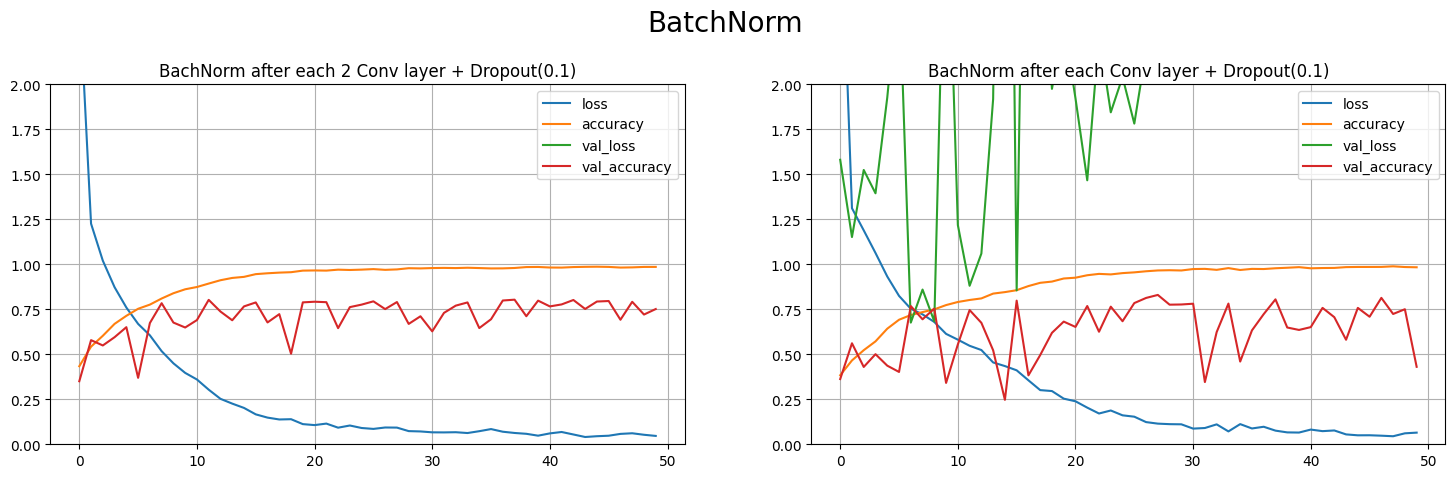

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plt.suptitle("BatchNorm", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(history4.history).plot(ax=axes[0])
axes[0].set_title("BachNorm after each 2 Conv layer + Dropout(0.1)")
axes[0].grid(True)
axes[0].set_ylim(0,2)

pd.DataFrame(history5.history).plot(ax=axes[1])
axes[1].set_title("BachNorm after each Conv layer + Dropout(0.1)")
axes[1].grid(True)
axes[1].set_ylim(0,2)

plt.show()

### 6 - val_acc = 86.50%
He_normal + Dropout(0.1)

In [53]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model6 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.1),
    Dense(units=128, activation='relu'),
    Dropout(0.1),
    Dense(units=64, activation='relu'),
    Dropout(0.1),
    Dense(units=6, activation='softmax')
])

model6.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history6 = model6.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 106ms/step - loss: 2.1058 - accuracy: 0.4389 - val_loss: 1.1673 - val_accuracy: 0.5411
Epoch 2/50
351/351 [==============================] - 37s 104ms/step - loss: 1.0275 - accuracy: 0.6005 - val_loss: 0.8201 - val_accuracy: 0.6751
Epoch 3/50
351/351 [==============================] - 37s 105ms/step - loss: 0.8556 - accuracy: 0.6800 - val_loss: 0.7571 - val_accuracy: 0.7253
Epoch 4/50
351/351 [==============================] - 37s 105ms/step - loss: 0.7563 - accuracy: 0.7243 - val_loss: 0.8024 - val_accuracy: 0.7100
Epoch 5/50
351/351 [==============================] - 37s 107ms/step - loss: 0.6685 - accuracy: 0.7634 - val_loss: 0.6596 - val_accuracy: 0.7716
Epoch 6/50
351/351 [==============================] - 37s 104ms/step - loss: 0.6185 - accuracy: 0.7844 - val_loss: 0.5915 - val_accuracy: 0.8016
Epoch 7/50
351/351 [==============================] - 37s 105ms/step - loss: 0.5869 - accuracy: 0.7959 - val_loss: 0.6277 - val_ac

### 7 - val_acc = 77.88%
He_normal + Dropout(0.5)

In [54]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model7 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=6, activation='softmax')
])

model7.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history7 = model7.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 105ms/step - loss: 4.5586 - accuracy: 0.2267 - val_loss: 1.6042 - val_accuracy: 0.2925
Epoch 2/50
351/351 [==============================] - 37s 105ms/step - loss: 1.6854 - accuracy: 0.2880 - val_loss: 1.6582 - val_accuracy: 0.2590
Epoch 3/50
351/351 [==============================] - 37s 105ms/step - loss: 1.6197 - accuracy: 0.2946 - val_loss: 1.5521 - val_accuracy: 0.3570
Epoch 4/50
351/351 [==============================] - 37s 106ms/step - loss: 1.5628 - accuracy: 0.3106 - val_loss: 1.4689 - val_accuracy: 0.3534
Epoch 5/50
351/351 [==============================] - 37s 105ms/step - loss: 1.5645 - accuracy: 0.3072 - val_loss: 1.4485 - val_accuracy: 0.3905
Epoch 6/50
351/351 [==============================] - 37s 105ms/step - loss: 1.5433 - accuracy: 0.3198 - val_loss: 1.4841 - val_accuracy: 0.3395
Epoch 7/50
351/351 [==============================] - 37s 104ms/step - loss: 1.5183 - accuracy: 0.3200 - val_loss: 1.4198 - val_ac

### 8 - val_acc = 86.57%
He_normal + Dropout(0.3)

In [55]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model8 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=128, activation='relu'),
    Dropout(0.3),
    Dense(units=64, activation='relu'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model8.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history8 = model8.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 108ms/step - loss: 2.9891 - accuracy: 0.3170 - val_loss: 1.3583 - val_accuracy: 0.4585
Epoch 2/50
351/351 [==============================] - 37s 105ms/step - loss: 1.4718 - accuracy: 0.4236 - val_loss: 1.0845 - val_accuracy: 0.5696
Epoch 3/50
351/351 [==============================] - 37s 105ms/step - loss: 1.2848 - accuracy: 0.4789 - val_loss: 1.0215 - val_accuracy: 0.5511
Epoch 4/50
351/351 [==============================] - 37s 104ms/step - loss: 1.1796 - accuracy: 0.5308 - val_loss: 0.9822 - val_accuracy: 0.6135
Epoch 5/50
351/351 [==============================] - 37s 105ms/step - loss: 1.0348 - accuracy: 0.5914 - val_loss: 0.8277 - val_accuracy: 0.6993
Epoch 6/50
351/351 [==============================] - 37s 104ms/step - loss: 0.9564 - accuracy: 0.6350 - val_loss: 0.8014 - val_accuracy: 0.7154
Epoch 7/50
351/351 [==============================] - 37s 104ms/step - loss: 0.9094 - accuracy: 0.6581 - val_loss: 0.8078 - val_ac

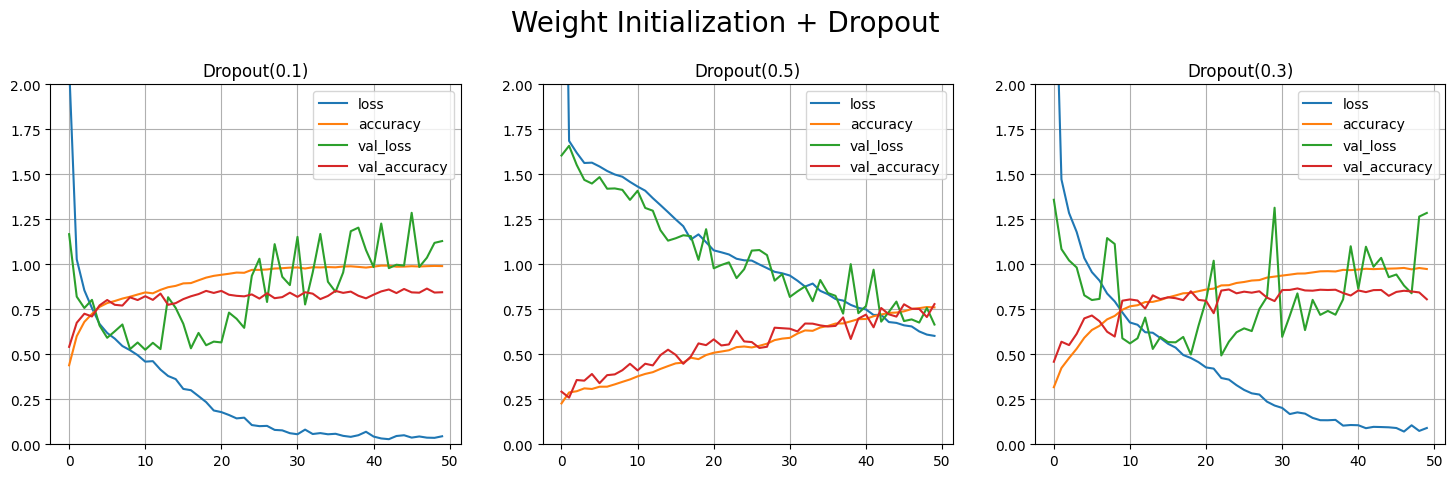

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Weight Initialization + Dropout", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(history6.history).plot(ax=axes[0])
axes[0].set_title("Dropout(0.1)")
axes[0].grid(True)
axes[0].set_ylim(0,2)

pd.DataFrame(history7.history).plot(ax=axes[1])
axes[1].set_title("Dropout(0.5)")
axes[1].grid(True)
axes[1].set_ylim(0,2)

pd.DataFrame(history8.history).plot(ax=axes[2])
axes[2].set_title("Dropout(0.3)")
axes[2].grid(True)
axes[2].set_ylim(0,2)

plt.show()

### 9 - val_acc = 85.07%
Regularization L1L2

In [60]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model9 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu', kernel_regularizer='l1_l2'),
    Dropout(0.3),
    Dense(units=128, activation='relu', kernel_regularizer='l1_l2'),
    Dropout(0.3),
    Dense(units=64, activation='relu', kernel_regularizer='l1_l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model9.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history9 = model9.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 107ms/step - loss: 50.0044 - accuracy: 0.3547 - val_loss: 17.7990 - val_accuracy: 0.3627
Epoch 2/50
351/351 [==============================] - 37s 106ms/step - loss: 15.1243 - accuracy: 0.4387 - val_loss: 13.8836 - val_accuracy: 0.3840
Epoch 3/50
351/351 [==============================] - 37s 105ms/step - loss: 13.3301 - accuracy: 0.4646 - val_loss: 13.1274 - val_accuracy: 0.4236
Epoch 4/50
351/351 [==============================] - 37s 106ms/step - loss: 13.0556 - accuracy: 0.4976 - val_loss: 12.9727 - val_accuracy: 0.5283
Epoch 5/50
351/351 [==============================] - 37s 105ms/step - loss: 13.1050 - accuracy: 0.5182 - val_loss: 13.3465 - val_accuracy: 0.4403
Epoch 6/50
351/351 [==============================] - 37s 106ms/step - loss: 13.2047 - accuracy: 0.5331 - val_loss: 13.3372 - val_accuracy: 0.5682
Epoch 7/50
351/351 [==============================] - 37s 105ms/step - loss: 13.3138 - accuracy: 0.5513 - val_loss: 13

### 10 - val_acc = 85.50%
Regularization L1

In [57]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model10 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu', kernel_regularizer='l1'),
    Dropout(0.3),
    Dense(units=128, activation='relu', kernel_regularizer='l1'),
    Dropout(0.3),
    Dense(units=64, activation='relu', kernel_regularizer='l1'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model10.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history10 = model10.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 107ms/step - loss: 53.5572 - accuracy: 0.3994 - val_loss: 20.9308 - val_accuracy: 0.5486
Epoch 2/50
351/351 [==============================] - 37s 107ms/step - loss: 16.7530 - accuracy: 0.4888 - val_loss: 14.6298 - val_accuracy: 0.5037
Epoch 3/50
351/351 [==============================] - 37s 106ms/step - loss: 13.7253 - accuracy: 0.4939 - val_loss: 13.1572 - val_accuracy: 0.5504
Epoch 4/50
351/351 [==============================] - 38s 107ms/step - loss: 13.1323 - accuracy: 0.5172 - val_loss: 12.9372 - val_accuracy: 0.5558
Epoch 5/50
351/351 [==============================] - 37s 106ms/step - loss: 13.1026 - accuracy: 0.5344 - val_loss: 12.8410 - val_accuracy: 0.6053
Epoch 6/50
351/351 [==============================] - 37s 106ms/step - loss: 13.0756 - accuracy: 0.5494 - val_loss: 13.0987 - val_accuracy: 0.5479
Epoch 7/50
351/351 [==============================] - 37s 105ms/step - loss: 13.0538 - accuracy: 0.5652 - val_loss: 13

### 11 - val_acc = 87.78%
Regularization L2

In [58]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model11 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model11.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history11 = model11.fit(X_train, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 107ms/step - loss: 9.1862 - accuracy: 0.3271 - val_loss: 4.5243 - val_accuracy: 0.3584
Epoch 2/50
351/351 [==============================] - 37s 106ms/step - loss: 3.6486 - accuracy: 0.4364 - val_loss: 3.1999 - val_accuracy: 0.5159
Epoch 3/50
351/351 [==============================] - 37s 106ms/step - loss: 2.7770 - accuracy: 0.5253 - val_loss: 2.3890 - val_accuracy: 0.6131
Epoch 4/50
351/351 [==============================] - 37s 105ms/step - loss: 2.2065 - accuracy: 0.5978 - val_loss: 1.9782 - val_accuracy: 0.6035
Epoch 5/50
351/351 [==============================] - 37s 106ms/step - loss: 1.8934 - accuracy: 0.6478 - val_loss: 1.6179 - val_accuracy: 0.7225
Epoch 6/50
351/351 [==============================] - 37s 104ms/step - loss: 1.5675 - accuracy: 0.7081 - val_loss: 1.2396 - val_accuracy: 0.7727
Epoch 7/50
351/351 [==============================] - 37s 105ms/step - loss: 1.3638 - accuracy: 0.7375 - val_loss: 1.0621 - val_ac

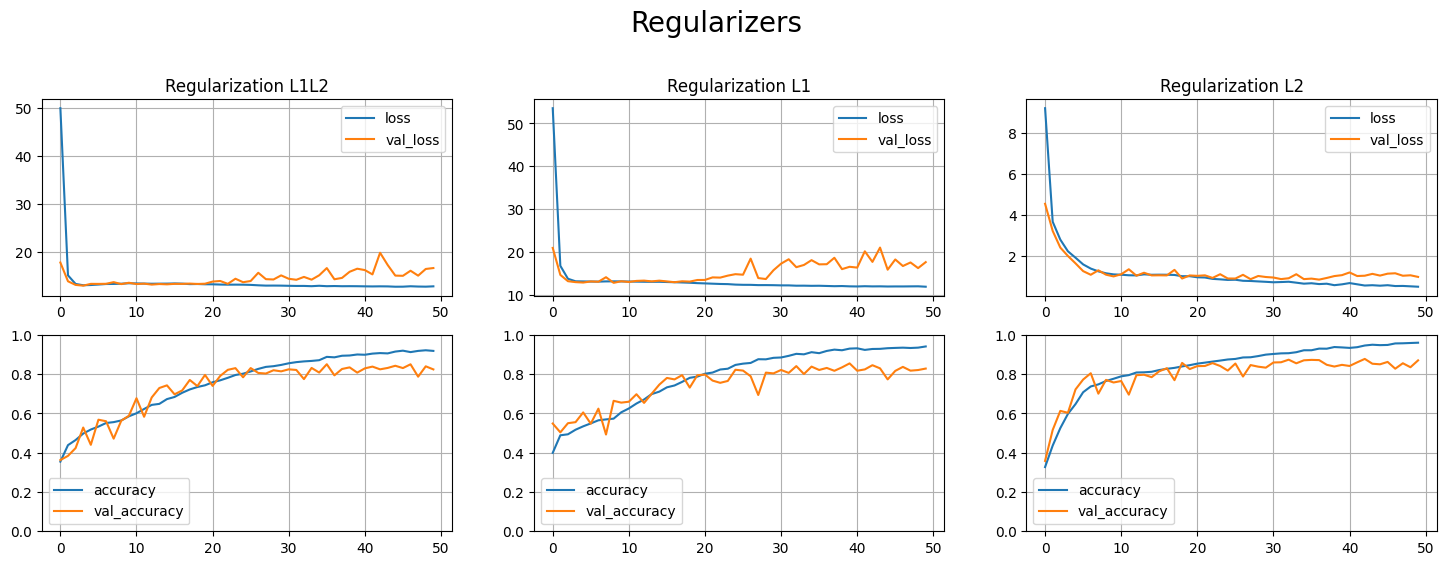

In [94]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
plt.suptitle("Regularizers", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(pd.DataFrame({'loss': history9.history['loss'], 'val_loss': history9.history['val_loss']})).plot(ax=axes[0][0])
axes[0][0].set_title("Regularization L1L2")
axes[0][0].grid(True)
pd.DataFrame(pd.DataFrame({'loss': history10.history['loss'], 'val_loss': history10.history['val_loss']})).plot(ax=axes[0][1])
axes[0][1].set_title("Regularization L1")
axes[0][1].grid(True)
pd.DataFrame(pd.DataFrame({'loss': history11.history['loss'], 'val_loss': history11.history['val_loss']})).plot(ax=axes[0][2])
axes[0][2].set_title("Regularization L2")
axes[0][2].grid(True)

pd.DataFrame(pd.DataFrame({'accuracy': history9.history['accuracy'], 'val_accuracy': history9.history['val_accuracy']})).plot(ax=axes[1][0])
axes[1][0].grid(True)
axes[1][0].set_ylim(0,1)
pd.DataFrame(pd.DataFrame({'accuracy': history10.history['accuracy'], 'val_accuracy': history10.history['val_accuracy']})).plot(ax=axes[1][1])
axes[1][1].grid(True)
axes[1][1].set_ylim(0,1)
pd.DataFrame(pd.DataFrame({'accuracy': history11.history['accuracy'], 'val_accuracy': history11.history['val_accuracy']})).plot(ax=axes[1][2])
axes[1][2].grid(True)
axes[1][2].set_ylim(0,1)

plt.show()

In [5]:
DataAugmentation = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

X_Augm = Datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 11227 validated image filenames belonging to 6 classes.


### 12 - val_acc = 88.64%
Data Augmentation + ReLU

In [64]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')

model12 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model12.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history12 = model12.fit(X_Augm, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 44s 106ms/step - loss: 10.1973 - accuracy: 0.2968 - val_loss: 5.0243 - val_accuracy: 0.3701
Epoch 2/50
351/351 [==============================] - 37s 106ms/step - loss: 4.1174 - accuracy: 0.4010 - val_loss: 3.3731 - val_accuracy: 0.5497
Epoch 3/50
351/351 [==============================] - 37s 105ms/step - loss: 3.1065 - accuracy: 0.4937 - val_loss: 2.5955 - val_accuracy: 0.6156
Epoch 4/50
351/351 [==============================] - 37s 105ms/step - loss: 2.4671 - accuracy: 0.5902 - val_loss: 2.1593 - val_accuracy: 0.6441
Epoch 5/50
351/351 [==============================] - 37s 105ms/step - loss: 2.0417 - accuracy: 0.6475 - val_loss: 2.3190 - val_accuracy: 0.5169
Epoch 6/50
351/351 [==============================] - 37s 105ms/step - loss: 1.7724 - accuracy: 0.6892 - val_loss: 2.3892 - val_accuracy: 0.4735
Epoch 7/50
351/351 [==============================] - 37s 105ms/step - loss: 1.5450 - accuracy: 0.7187 - val_loss: 2.9949 - val_a

### 13 - val_acc = 89.38%
Data Augmentation + ELU

In [73]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')

model13 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=128, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model13.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history13 = model13.fit(X_Augm, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 49s 117ms/step - loss: 10.6105 - accuracy: 0.3363 - val_loss: 4.8354 - val_accuracy: 0.4296
Epoch 2/50
351/351 [==============================] - 39s 111ms/step - loss: 4.1942 - accuracy: 0.4257 - val_loss: 3.1577 - val_accuracy: 0.5586
Epoch 3/50
351/351 [==============================] - 39s 112ms/step - loss: 3.0486 - accuracy: 0.5068 - val_loss: 2.5138 - val_accuracy: 0.6056
Epoch 4/50
351/351 [==============================] - 40s 113ms/step - loss: 2.4350 - accuracy: 0.5895 - val_loss: 2.0281 - val_accuracy: 0.6876
Epoch 5/50
351/351 [==============================] - 39s 112ms/step - loss: 1.9785 - accuracy: 0.6545 - val_loss: 1.8664 - val_accuracy: 0.6409
Epoch 6/50
351/351 [==============================] - 39s 111ms/step - loss: 1.6453 - accuracy: 0.7058 - val_loss: 1.4281 - val_accuracy: 0.7545
Epoch 7/50
351/351 [==============================] - 40s 112ms/step - loss: 1.3571 - accuracy: 0.7490 - val_loss: 1.2975 - val_a

### 14 - val_acc = 88.46%
Data Augmentation + LeakyReLU

In [74]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal')

model14 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=256, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=128, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model14.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history14 = model14.fit(X_Augm, verbose=1, epochs=50, validation_data=X_valid, validation_steps=None, callbacks=model_checkpoint_callback)

Epoch 1/50
351/351 [==============================] - 46s 112ms/step - loss: 13.9550 - accuracy: 0.4028 - val_loss: 6.6492 - val_accuracy: 0.4304
Epoch 2/50
351/351 [==============================] - 39s 110ms/step - loss: 6.1756 - accuracy: 0.4745 - val_loss: 4.8684 - val_accuracy: 0.5230
Epoch 3/50
351/351 [==============================] - 39s 111ms/step - loss: 4.2578 - accuracy: 0.5387 - val_loss: 3.8226 - val_accuracy: 0.6477
Epoch 4/50
351/351 [==============================] - 39s 111ms/step - loss: 4.0619 - accuracy: 0.5916 - val_loss: 3.3757 - val_accuracy: 0.5782
Epoch 5/50
351/351 [==============================] - 39s 111ms/step - loss: 2.8780 - accuracy: 0.6632 - val_loss: 2.6198 - val_accuracy: 0.6708
Epoch 6/50
351/351 [==============================] - 39s 112ms/step - loss: 2.3716 - accuracy: 0.7015 - val_loss: 2.2633 - val_accuracy: 0.6512
Epoch 7/50
351/351 [==============================] - 39s 111ms/step - loss: 1.9871 - accuracy: 0.7363 - val_loss: 1.7322 - val_a

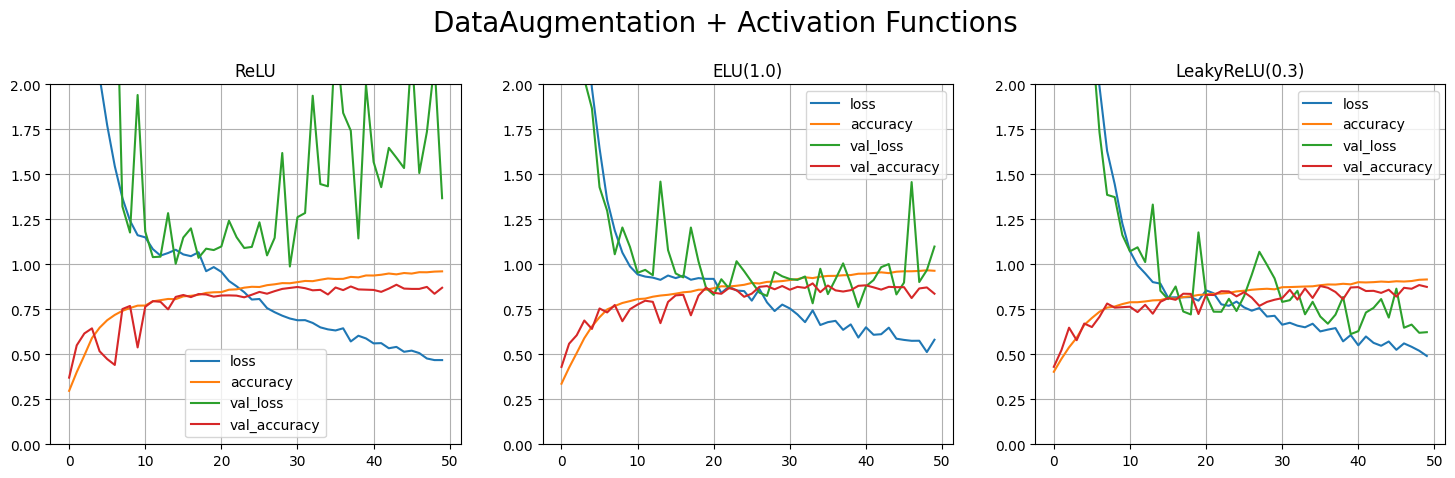

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plt.suptitle("DataAugmentation + Activation Functions\n", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(history12.history).plot(ax=axes[0])
axes[0].set_title("ReLU")
axes[0].grid(True)
axes[0].set_ylim(0,2)

pd.DataFrame(history13.history).plot(ax=axes[1])
axes[1].set_title("ELU(1.0)")
axes[1].grid(True)
axes[1].set_ylim(0,2)

pd.DataFrame(history14.history).plot(ax=axes[2])
axes[2].set_title("LeakyReLU(0.3)")
axes[2].grid(True)
axes[2].set_ylim(0,2)

plt.show()

### 15 - val_acc = 89.17%
LeakyReLU + +1 layer

In [11]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal')

model15 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=1024),
    BatchNormalization(),
    DefaultConv2D(filters=1024),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=512, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=256, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=128, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model15.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history15 = model15.fit(X_Augm, verbose=1, epochs=70, validation_data=X_valid, callbacks=model_checkpoint_callback)

Epoch 1/70
351/351 [==============================] - 62s 143ms/step - loss: 14.5463 - accuracy: 0.3426 - val_loss: 7.9687 - val_accuracy: 0.4186
Epoch 2/70
351/351 [==============================] - 48s 137ms/step - loss: 6.6216 - accuracy: 0.4912 - val_loss: 5.2933 - val_accuracy: 0.5914
Epoch 3/70
351/351 [==============================] - 48s 138ms/step - loss: 5.0677 - accuracy: 0.5408 - val_loss: 3.9183 - val_accuracy: 0.5999
Epoch 4/70
351/351 [==============================] - 49s 138ms/step - loss: 3.5043 - accuracy: 0.6491 - val_loss: 3.0299 - val_accuracy: 0.6872
Epoch 5/70
351/351 [==============================] - 48s 138ms/step - loss: 2.6757 - accuracy: 0.7200 - val_loss: 2.3618 - val_accuracy: 0.7004
Epoch 6/70
351/351 [==============================] - 49s 138ms/step - loss: 2.0237 - accuracy: 0.7485 - val_loss: 1.7197 - val_accuracy: 0.7684
Epoch 7/70
351/351 [==============================] - 49s 138ms/step - loss: 1.5850 - accuracy: 0.7709 - val_loss: 1.7469 - val_a

In [15]:
model15.load_weights('/tmp/checkpoint')
model15.evaluate(X_test)

94/94 [==============================] - 29s 313ms/step - loss: 0.6692 - accuracy: 0.8893


[0.6691836714744568, 0.8893333077430725]

### 16 - val_acc = 87.17%
LeakyReLU + -1 layer

In [17]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU(), padding='same', kernel_initializer='he_normal')

model16 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(), kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model16.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history16 = model16.fit(X_Augm, verbose=1, epochs=70, validation_data=X_valid, callbacks=model_checkpoint_callback)

Epoch 1/70
351/351 [==============================] - 42s 103ms/step - loss: 17.7068 - accuracy: 0.4383 - val_loss: 7.8799 - val_accuracy: 0.2932
Epoch 2/70
351/351 [==============================] - 36s 103ms/step - loss: 7.5139 - accuracy: 0.4714 - val_loss: 3.9052 - val_accuracy: 0.6131
Epoch 3/70
351/351 [==============================] - 36s 102ms/step - loss: 2.6956 - accuracy: 0.5911 - val_loss: 1.7423 - val_accuracy: 0.7171
Epoch 4/70
351/351 [==============================] - 36s 101ms/step - loss: 1.7556 - accuracy: 0.6738 - val_loss: 1.4830 - val_accuracy: 0.7585
Epoch 5/70
351/351 [==============================] - 36s 102ms/step - loss: 1.6282 - accuracy: 0.7064 - val_loss: 1.4471 - val_accuracy: 0.7506
Epoch 6/70
351/351 [==============================] - 36s 102ms/step - loss: 1.4955 - accuracy: 0.7382 - val_loss: 1.3766 - val_accuracy: 0.7485
Epoch 7/70
351/351 [==============================] - 36s 103ms/step - loss: 1.4039 - accuracy: 0.7604 - val_loss: 1.2361 - val_a

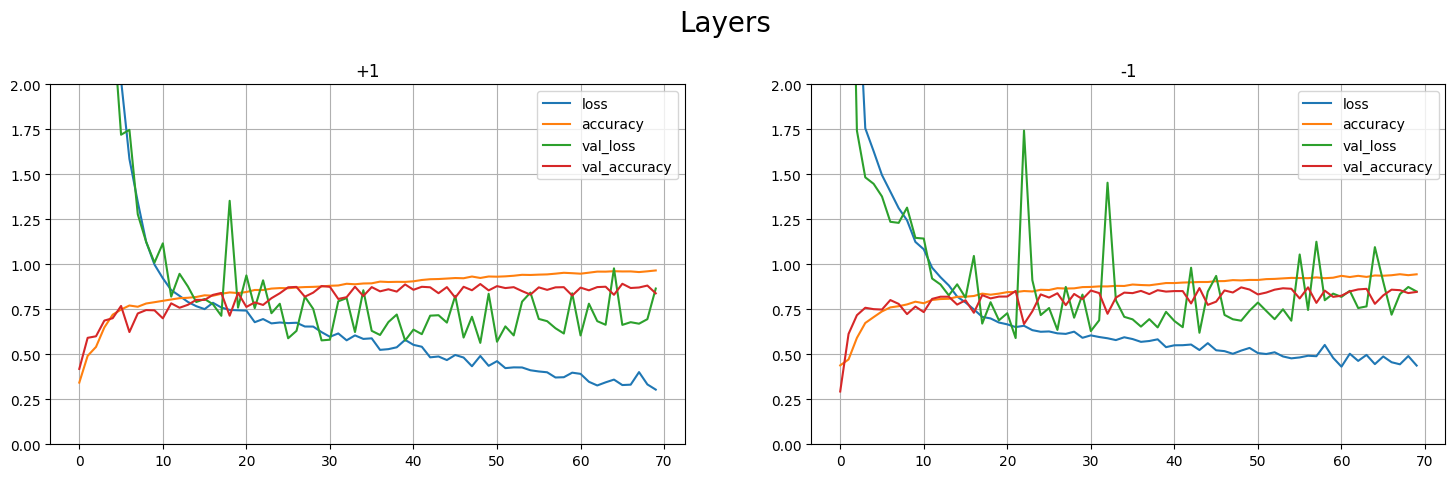

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plt.suptitle("Layers", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(history15.history).plot(ax=axes[0])
axes[0].set_title("+1")
axes[0].grid(True)
axes[0].set_ylim(0,2)

pd.DataFrame(history16.history).plot(ax=axes[1])
axes[1].set_title("-1")
axes[1].grid(True)
axes[1].set_ylim(0,2)

plt.show()

### 17 - val_acc = 90.06%
ELU + +1 layer

In [6]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')

model17 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=512),
    BatchNormalization(),
    DefaultConv2D(filters=512),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=1024),
    BatchNormalization(),
    DefaultConv2D(filters=1024),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=512, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=256, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=128, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model17.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history17 = model17.fit(X_Augm, verbose=1, epochs=70, validation_data=X_valid, callbacks=model_checkpoint_callback)

Epoch 1/70
351/351 [==============================] - 105s 244ms/step - loss: 12.0752 - accuracy: 0.3487 - val_loss: 6.0023 - val_accuracy: 0.4328
Epoch 2/70
351/351 [==============================] - 48s 138ms/step - loss: 4.7674 - accuracy: 0.5101 - val_loss: 3.5805 - val_accuracy: 0.6377
Epoch 3/70
351/351 [==============================] - 49s 140ms/step - loss: 3.0672 - accuracy: 0.6261 - val_loss: 2.5455 - val_accuracy: 0.6623
Epoch 4/70
351/351 [==============================] - 49s 138ms/step - loss: 2.0892 - accuracy: 0.7096 - val_loss: 1.7207 - val_accuracy: 0.7107
Epoch 5/70
351/351 [==============================] - 49s 139ms/step - loss: 1.5086 - accuracy: 0.7580 - val_loss: 1.2224 - val_accuracy: 0.7830
Epoch 6/70
351/351 [==============================] - 48s 136ms/step - loss: 1.1714 - accuracy: 0.7804 - val_loss: 1.1037 - val_accuracy: 0.7674
Epoch 7/70
351/351 [==============================] - 49s 140ms/step - loss: 0.9900 - accuracy: 0.7958 - val_loss: 0.8432 - val_

In [9]:
model17.load_weights('/tmp/checkpoint')
model17.evaluate(X_test)

94/94 [==============================] - 22s 232ms/step - loss: 0.6075 - accuracy: 0.8950


[0.6075493693351746, 0.8949999809265137]

### 18 - val_acc = 88.10%
ELU + -1 layer

In [7]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='elu', padding='same', kernel_initializer='he_normal')

model18 = Sequential([
    DefaultConv2D(filters=64, input_shape=(150,150,3)),
    BatchNormalization(),
    DefaultConv2D(filters=64),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    
    DefaultConv2D(filters=128),
    BatchNormalization(),
    DefaultConv2D(filters=128),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    DefaultConv2D(filters=256),
    BatchNormalization(),
    DefaultConv2D(filters=256),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(units=128, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=64, activation='elu', kernel_regularizer='l2'),
    Dropout(0.3),
    Dense(units=6, activation='softmax')
])

model18.compile(loss="categorical_crossentropy", 
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"])
history18 = model18.fit(X_Augm, verbose=1, epochs=70, validation_data=X_valid, callbacks=model_checkpoint_callback)

Epoch 1/70
351/351 [==============================] - 40s 99ms/step - loss: 8.8884 - accuracy: 0.3008 - val_loss: 4.0734 - val_accuracy: 0.2390
Epoch 2/70
351/351 [==============================] - 34s 98ms/step - loss: 3.1776 - accuracy: 0.3135 - val_loss: 2.7235 - val_accuracy: 0.4250
Epoch 3/70
351/351 [==============================] - 35s 99ms/step - loss: 2.7941 - accuracy: 0.3587 - val_loss: 2.1781 - val_accuracy: 0.4856
Epoch 4/70
351/351 [==============================] - 35s 99ms/step - loss: 2.5170 - accuracy: 0.3923 - val_loss: 2.0955 - val_accuracy: 0.4927
Epoch 5/70
351/351 [==============================] - 35s 98ms/step - loss: 2.3097 - accuracy: 0.4087 - val_loss: 1.8985 - val_accuracy: 0.4902
Epoch 6/70
351/351 [==============================] - 34s 97ms/step - loss: 1.9275 - accuracy: 0.4571 - val_loss: 1.7509 - val_accuracy: 0.5686
Epoch 7/70
351/351 [==============================] - 35s 98ms/step - loss: 1.8273 - accuracy: 0.4902 - val_loss: 1.6877 - val_accuracy:

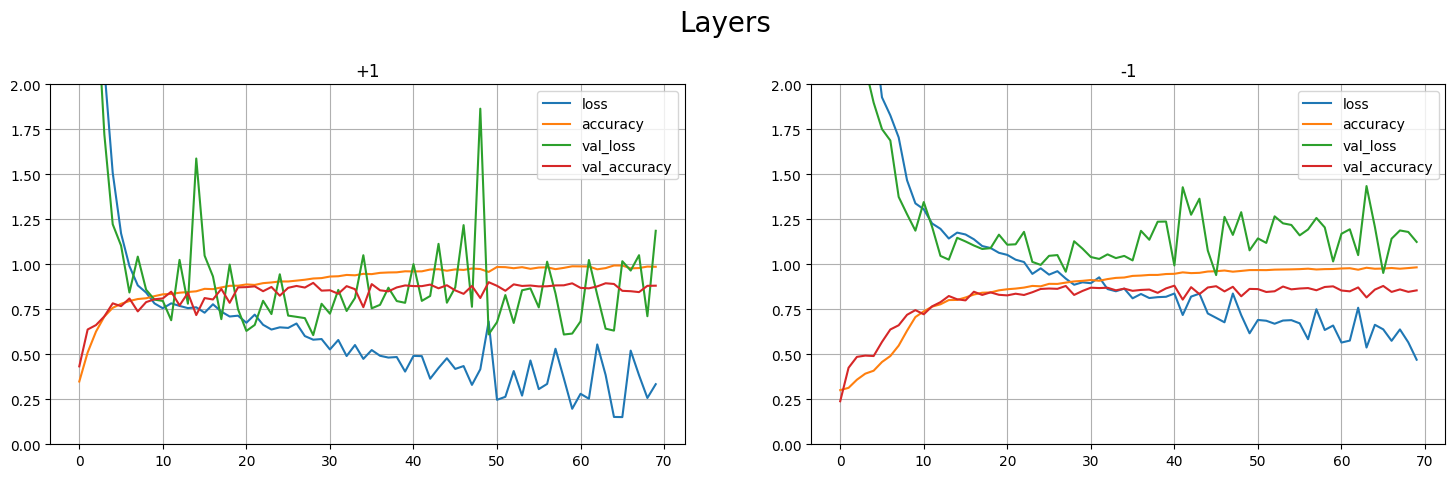

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plt.suptitle("Layers", size=20)
plt.subplots_adjust(top=0.83)

pd.DataFrame(history17.history).plot(ax=axes[0])
axes[0].set_title("+1")
axes[0].grid(True)
axes[0].set_ylim(0,2)

pd.DataFrame(history18.history).plot(ax=axes[1])
axes[1].set_title("-1")
axes[1].grid(True)
axes[1].set_ylim(0,2)

plt.show()